# Deep NN

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

In [5]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [6]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [7]:
# imdb data
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

In [33]:
# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# descriptive model name
model_name = "deep_nn__%s" % "_".join(map(str, n_hidden))

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# number of data points
N = x_train.shape[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# GloVe Word Embedding

In [9]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [10]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

In [11]:
# raw data representation
print(x_train[0], y_train[0])

[1, 11, 19, 13, 40, 527, 970, 1619, 1382, 62, 455, 4465, 63, 3938, 1, 170, 33, 253, 2, 22, 97, 40, 835, 109, 47, 667, 22662, 6, 32, 477, 281, 2, 147, 1, 169, 109, 164, 21628, 333, 382, 36, 1, 169, 4533, 1108, 14, 543, 35, 10, 444, 1, 189, 47, 13, 3, 144, 2022, 16, 11, 19, 1, 1917, 4610, 466, 1, 19, 68, 84, 9, 13, 40, 527, 35, 73, 12, 10, 1244, 1, 19, 14, 512, 14, 9, 13, 623, 15, 19190, 2, 59, 383, 9, 5, 313, 5, 103, 2, 1, 2220, 5241, 13, 477, 63, 3782, 30, 1, 127, 9, 13, 35, 616, 2, 22, 121, 48, 33, 132, 45, 22, 1412, 30, 3, 19, 9, 212, 25, 74, 49, 2, 11, 404, 13, 79, 10308, 5, 1, 104, 114, 5949, 12, 253, 1, 31047, 4, 3763, 2, 720, 33, 68, 40, 527, 473, 23, 397, 314, 43, 4, 1, 12115, 1026, 10, 101, 85, 1, 378, 12, 294, 95, 29, 2068, 53, 23, 138, 3, 191, 7483, 15, 1, 223, 19, 18, 131, 473, 23, 477, 2, 141, 27, 5532, 15, 48, 33, 25, 221, 89, 22, 101, 1, 223, 62, 13, 35, 1331, 85, 9, 13, 280, 2, 13, 4469, 110, 100, 29, 12, 13, 5342, 16, 175, 29] 1


In [12]:
# parsed sentence
print(word_index.vec2sentence(x_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited <START> part they played <UNK> you could just imagine being there robert redford's is an amazing actor <UNK> now <START> same being director norman's father came from <START> same scottish island as myself so i loved <START> fact there was a real connection with this film <START> witty remarks throughout <START> film were great it was just brilliant so much that i bought <START> film as soon as it was released for retail <UNK> would recommend it to everyone to watch <UNK> <START> fly fishing was amazing really cried at <START> end it was so sad <UNK> you know what they say if you cry at a film it must have been good <UNK> this definitely was also congratulations to <START> two little boy's that played <START> part's of norman <UNK> paul they were just brilliant children are often left out of <START> praising list i think because <START> stars that play them all grown up are such a big

# History

In [35]:
try:
    history_df = pd.read_csv(history_save_file, sep=";", index_col="epoch")
    last_epoch = history_df.index[-1] + 1
    print("Last epoch: %i" % last_epoch)
except FileNotFoundError:
    print("No saved history file")
    last_epoch = 0

Last epoch: 20


# Model

In [29]:
metrics = [
    "acc",
    tfk.metrics.TrueNegatives(name="true_negatives"),
    tfk.metrics.FalseNegatives(name="false_negatives"),
    tfk.metrics.TruePositives(name="true_positives"),
    tfk.metrics.FalsePositives(name="false_positives"),
    tfk.metrics.Precision(name="precision"),
    tfk.metrics.Recall(name="recall"),
    tfk.metrics.KLDivergence(name="kl"),
]

embedding_layer = tfkl.Embedding(len(word_index.index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

def create_model():
    model = tfk.Sequential(name="model_%s" % model_name)
    model.add(embedding_layer)
    for i in range(len(n_hidden)):
        model.add(tfkl.Dense(n_hidden[i], activation='relu', kernel_regularizer=tfk.regularizers.l2(0.01)))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return model

try:
    model = tfk.models.load_model(model_save_file)
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")
    
model.summary()

model has not been trained (IOError)
Model: "model_deep_nn__64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dense_8 (Dense)              (None, 2697, 64)          3264      
_________________________________________________________________
dense_9 (Dense)              (None, 2697, 64)          4160      
_________________________________________________________________
dense_10 (Dense)             (None, 2697, 32)          2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 86304)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 86305     
Total params: 4,525,209
Trainable params: 95,809
Non-trainable params: 4

In [34]:
# keras callbacks
csv_logger = tfk.callbacks.CSVLogger(history_save_file, append=True, separator=';')
model_checkpoint_cb = tfk.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=0, 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      mode='auto')

model.fit(x_train_padded, 
          y_train, 
          validation_split=validation_split,
          initial_epoch=last_epoch,
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[csv_logger, model_checkpoint_cb])

Train on 23750 samples, validate on 1250 samples
Epoch 11/20
23750/23750 [==============================] - 12s 496us/sample - loss: 0.4915 - acc: 0.8223 - true_negatives: 9629.0000 - false_negatives: 1976.0000 - true_positives: 9900.0000 - false_positives: 2245.0000 - precision: 0.8152 - recall: 0.8336 - kl: 0.2047 - val_loss: 0.5395 - val_acc: 0.8016 - val_true_negatives: 447.0000 - val_false_negatives: 69.0000 - val_true_positives: 555.0000 - val_false_positives: 179.0000 - val_precision: 0.7561 - val_recall: 0.8894 - val_kl: 0.1699
Epoch 12/20
23750/23750 [==============================] - 12s 500us/sample - loss: 0.4804 - acc: 0.8255 - true_negatives: 9640.0000 - false_negatives: 1910.0000 - true_positives: 9966.0000 - false_positives: 2234.0000 - precision: 0.8169 - recall: 0.8392 - kl: 0.1982 - val_loss: 0.5336 - val_acc: 0.8136 - val_true_negatives: 529.0000 - val_false_negatives: 136.0000 - val_true_positives: 488.0000 - val_false_positives: 97.0000 - val_precision: 0.8342 - v

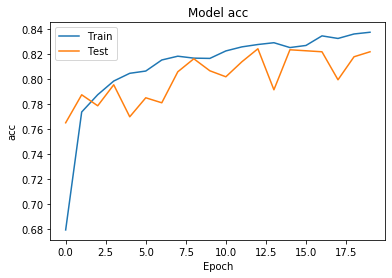

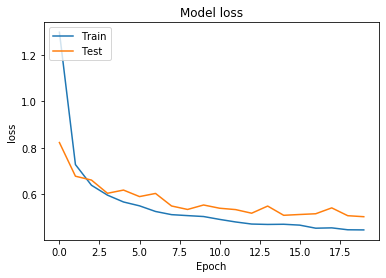

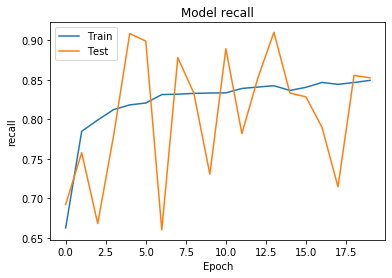

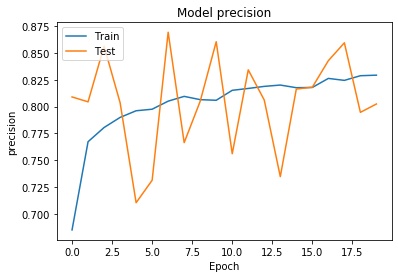

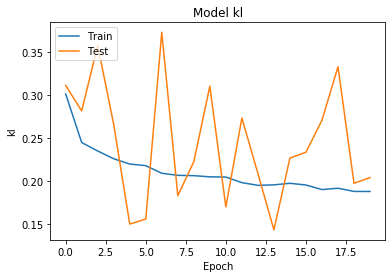

In [36]:
def plot_metric(name, history_df):
    plt.plot(history_df[name])
    plt.plot(history_df["val_%s" % name])
    plt.title('Model %s' % name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
for metric in ["acc", "loss", "recall", "precision", "kl"]:
    plot_metric(metric, history_df)

In [14]:
def test_model(x, y):
    test_result = np.round(model.predict(x))
    test_errors = np.squeeze(test_result) != y
    correct_percentage = np.sum(test_errors) / len(y)
    print("%i / %i (%.2f%%) are correct" % (len(y) - np.sum(test_errors), len(y), 100 * (1 - correct_percentage)))

In [15]:
test_model(x_test_padded, y_test)

21007 / 25000 (84.03%) are correct


In [38]:
sentences = [
    "this was a very bad movie",
    "this was a very good movie",
    "I did not like this movie at all",
    "I hope there will be a sequal",
    "not bad",
    "bad",
    "not good",
    "one of the best movies of the year",
    "the first part was bad but the second part got better",
    "the first part was not bad but after that it just got worse",
    "this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought"
]

rating = cm.Rating(word_index, model)
rating.print(rating.of(sentences))

⭐⭐⭐⭐ (35.63%)
this was a very bad movie

⭐⭐⭐⭐⭐⭐⭐ (67.03%)
this was a very good movie

⭐⭐⭐⭐⭐ (51.46%)
I did not like this movie at all

⭐⭐⭐⭐⭐ (48.75%)
I hope there will be a sequal

⭐⭐⭐ (29.91%)
not bad

⭐⭐⭐⭐⭐ (51.48%)
bad

⭐⭐⭐⭐⭐⭐ (58.63%)
not good

⭐⭐⭐⭐⭐⭐ (57.71%)
one of the best movies of the year

⭐⭐⭐⭐ (37.54%)
the first part was bad but the second part got better

⭐⭐ (17.84%)
the first part was not bad but after that it just got worse

⭐⭐⭐⭐⭐⭐⭐⭐⭐ (93.23%)
this film was just brilliant casting location scenery story direction everyone's really suited part they played you could just imagine being there robert redford's is an amazing actor now same being director norman's father came from same scottish island as myself so i loved fact there was a real connection with this film witty remarks throughout film were great it was just brilliant so much that i bought

